# Stima infetti reali

Stima infetti reali con fast backcasting.

> Max Pierini

***

In [1]:
import datetime as dt

import numpy as np
import pandas as pd
import scipy.stats as sps
import scipy.special as sc

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

from IPython.display import display, Markdown

In [2]:
def define_parameters(n_size,
                      cov1 = 0.86,
                      cov2 = 0.45,
                      dt_incub_min = 4.1,
                      dt_incub_max = 7.0,
                      dt_onset_min = 12.8,
                      dt_onset_max = 19.2,
                      ifr_min = 2.03 / 100,
                      ifr_max = 2.45 / 100,
                      y_size=101,
                      ci=.95,
                     ):

    ci_lo = (1 - ci) / 2
    ci_hi = 1 - ci_lo
    
    dt_incub_mu = 0.5 * (dt_incub_min + dt_incub_max)
    dt_onset_mu = 0.5 * (dt_onset_min + dt_onset_max)
    
    dt_incub_sd = (dt_incub_max - dt_incub_min) / (sps.norm.isf(ci_lo) - sps.norm.isf(ci_hi))
    dt_onset_sd = (dt_onset_max - dt_onset_min) / (sps.norm.isf(ci_lo) - sps.norm.isf(ci_hi))
    
    #dt_incub_dist = sps.norm(loc=dt_incub_mu, scale=dt_incub_sd)
    #dt_incub_lo = dt_incub_dist.ppf(ci_lo)
    #dt_incub_hi = dt_incub_dist.ppf(ci_hi)
    dt_incub_lo = dt_incub_mu - dt_incub_sd
    dt_incub_hi = dt_incub_mu + dt_incub_sd
    
    #dt_onset_dist = sps.norm(loc=dt_onset_mu, scale=dt_onset_sd)
    #dt_onset_lo = dt_onset_dist.ppf(ci_lo)
    #dt_onset_hi = dt_onset_dist.ppf(ci_hi)
    dt_onset_lo = dt_onset_mu - dt_onset_sd
    dt_onset_hi = dt_onset_mu + dt_onset_sd

    dt_death_lo = dt_incub_lo + dt_onset_lo
    dt_death_mu = dt_incub_mu + dt_onset_mu
    dt_death_hi = dt_incub_hi + dt_onset_hi

    ifr_mu = 0.5 * (ifr_min + ifr_max)
    ifr_sd = (ifr_max - ifr_min) / (sps.norm.isf(ci_lo) - sps.norm.isf(ci_hi))
    #ifr_dist = sps.norm(loc=ifr_mu, scale=ifr_sd)
    #ifr_lo = ifr_dist.ppf(ci_lo)
    #ifr_hi = ifr_dist.ppf(ci_hi)
    ifr_lo = ifr_mu - ifr_sd
    ifr_hi = ifr_mu + ifr_sd

    dt_df = pd.DataFrame({
        'incub': [dt_incub_lo, dt_incub_mu, dt_incub_hi],
        'onset': [dt_onset_lo, dt_onset_mu, dt_onset_hi],
        'IFR': [ifr_lo, ifr_mu, ifr_hi],
    }, index=['lo', 'mu', 'hi'])
    dt_df['death'] = dt_df.incub + dt_df.onset
    dt_df['incub_sd'] = dt_df.incub * cov1
    dt_df['onset_sd'] = dt_df.onset * cov2
    dt_df['death_sd'] = np.sqrt(dt_df.incub_sd**2 + dt_df.onset_sd**2)
    dt_df['_cov_'] = dt_df.death_sd / dt_df.death
    dt_df['alpha'] = 1.0 / dt_df._cov_**2
    dt_df['beta'] = dt_df.death * dt_df._cov_**2

    dt_dist = sps.gamma(
        a=dt_df.alpha.values.reshape(-1, 1), 
        scale=dt_df.beta.values.reshape(-1, 1)
    )
    gamma_x = np.arange(n_size)
    PDFs = dt_dist.pdf(gamma_x)
    PDFs[0,:] /= PDFs[0,:].sum()
    PDFs[1,:] /= PDFs[1,:].sum()
    PDFs[2,:] /= PDFs[2,:].sum()
    
    CDFs = PDFs.cumsum(axis=1)
    
    #tgamma = sps.gamma(
    #    a=dt_df.alpha.values.reshape(-1, 1), 
    #    scale=dt_df.beta.values.reshape(-1, 1)
    #)
    #tgamma_x = np.arange(n_size)
    #tgamma_y = tgamma.cdf(tgamma_x)
    
    return (dt_df, PDFs, CDFs, gamma_x)

In [3]:
def backcasting(d_omega, AWRs, PDFs, CDFs, index):
    
    size = d_omega.size
    
    d_alpha_raw = np.ndarray(shape=(3, 3, size))
    d_alpha_cor = np.ndarray(shape=(3, 3, size))
    
    # TODO: -1 ?
    for i_alpha in range(size):
        # define observed omega events
        i_omega_0 = i_alpha
        i_omega_T = size
        d_omega_obs = d_omega[i_omega_0:i_omega_T]
        # define last index for PDF of omega events
        i_PDF_T = size - i_omega_0
        #i_CDF = size - 1 - i_alpha
        #print(i_alpha, i_PDF_T, i_CDF)
        # loop through PDFs
        for i, PDF in enumerate(PDFs):
            pdf = PDF[0:i_PDF_T]
            #cdf = CDFs[i][i_CDF]
            cdf = CDFs[i][::-1][i_alpha]
            #print(i_alpha, cdf)
            # loop through AWRs
            for j, AWR in enumerate(AWRs):
                __alpha_raw_series = pdf * d_omega_obs / AWR
                __alpha_raw = np.sum(__alpha_raw_series)
                #__alpha_cor_series = (pdf / cdf) * (d_omega_obs / AWR)
                old_settings = np.seterr(all='ignore')
                __alpha_cor = __alpha_raw / cdf
                _ = np.seterr(**old_settings)
                d_alpha_raw[i,j,i_alpha] = __alpha_raw
                d_alpha_cor[i,j,i_alpha] = __alpha_cor

    d_alpha_raw_df = pd.DataFrame({
            'lo': d_alpha_raw.min(axis=0).min(axis=0),
            'mu': d_alpha_raw.mean(axis=0).mean(axis=0),
            'hi': d_alpha_raw.max(axis=0).max(axis=0),
        }, index=index
    )
    d_alpha_raw_df.dropna(inplace=True)
    
    d_alpha_cor_df = pd.DataFrame({
            'lo': d_alpha_cor.min(axis=0).min(axis=0),
            'mu': d_alpha_cor.mean(axis=0).mean(axis=0),
            'hi': d_alpha_cor.max(axis=0).max(axis=0),
        }, index=index
    )
    d_alpha_cor_df.dropna(inplace=True)
    
    c_alpha_raw_df = d_alpha_raw_df.cumsum(axis=0)
    c_alpha_cor_df = d_alpha_cor_df.cumsum(axis=0)
    
    d_alpha_adj_df = (d_alpha_raw_df + d_alpha_cor_df) / 2
    d_alpha_adj_df.dropna(inplace=True)
    c_alpha_adj_df = d_alpha_adj_df.cumsum(axis=0)
    
    res = {
        'c_alpha_raw': c_alpha_raw_df,
        'd_alpha_raw': d_alpha_raw_df,
        'c_alpha_cor': c_alpha_cor_df,
        'd_alpha_cor': d_alpha_cor_df,
        'c_alpha_adj': c_alpha_adj_df,
        'd_alpha_adj': d_alpha_adj_df,
    }
    
    return res

# ITALIA

In [4]:
df = pd.read_csv(
    "https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/"
    "dpc-covid19-ita-andamento-nazionale.csv",
    parse_dates=['data'], index_col='data'
)
df.index = df.index.normalize()

In [5]:
prev_dt_range = pd.date_range(
    pd.to_datetime('2020-01-01'),
    df.index[0] - pd.Timedelta(days=1)
)
prev_DPC = pd.DataFrame(columns=df.columns, index=prev_dt_range)

prev_DPC.loc[:,:] = 0

DF = prev_DPC.append(df)

DF['nuovi_deceduti'] = DF.deceduti.diff()
DF.loc[DF.nuovi_deceduti<0, 'nuovi_deceduti'] = np.nan

DF.fillna(0, inplace=True)

In [6]:
n_dfat = DF.nuovi_deceduti.values.ravel()

In [7]:
par_df2, PDFs2, CDFs2, xDF2 = define_parameters(
    n_dfat.size,
    ci=.95,
)

In [8]:
res2 = backcasting(
    n_dfat, par_df2.IFR.values, PDFs2, CDFs2, DF.index,
)

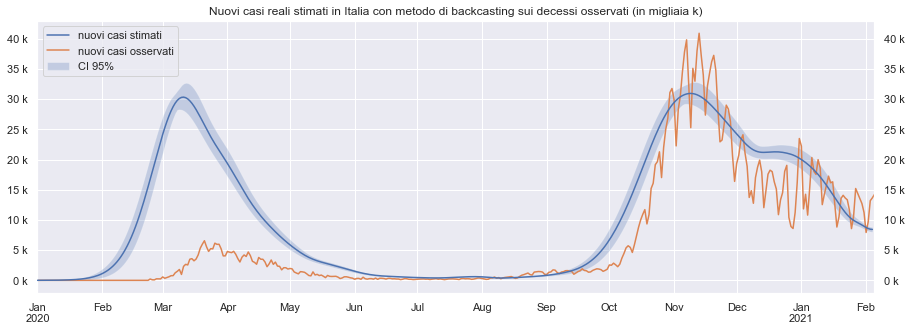

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
res2['d_alpha_adj'].mu.plot(ax=ax, zorder=100, label='nuovi casi stimati')
ax.fill_between(
    res2['d_alpha_adj'].index,
    res2['d_alpha_adj'].lo, res2['d_alpha_adj'].hi,
    alpha=.25, label='CI 95%'
)
DF.plot(y='nuovi_positivi', ax=ax, label='nuovi casi osservati')
ax.legend(loc='upper left')
ax.legend(loc='upper left')
ylim = ax.get_ylim()
ax.set(
    yticks=ax.get_yticks(),
    yticklabels=[f"{i:.0f} k" for i in ax.get_yticks()/1e3],
)
ax.set(
    title="Nuovi casi reali stimati in Italia con metodo di backcasting sui decessi osservati"
    " (in migliaia k)",
    ylim=ylim,
)
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)
plt.show()

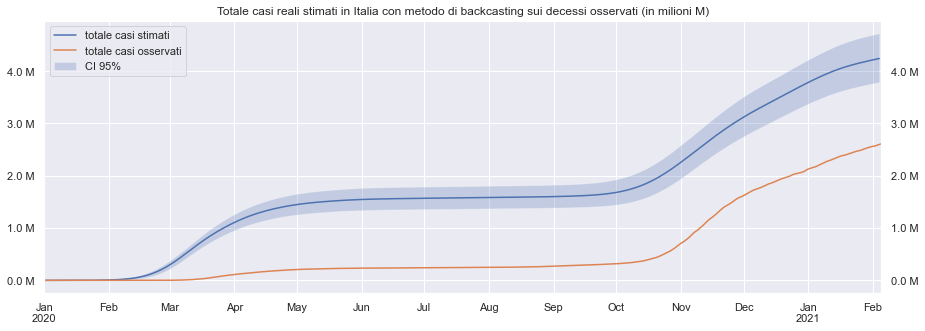

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
res2['c_alpha_adj'].mu.plot(ax=ax, label='totale casi stimati')
ax.fill_between(
    res2['c_alpha_adj'].index,
    res2['c_alpha_adj'].lo, res2['c_alpha_adj'].hi,
    alpha=.25, label='CI 95%'
)
DF.plot(y='totale_casi', ax=ax, label='totale casi osservati')
ax.legend(loc='upper left')
ylim = ax.get_ylim()
ax.set(
    yticks=ax.get_yticks(),
    yticklabels=[f"{i:.1f} M" for i in ax.get_yticks()/1e6],
)
ax.set(
    title="Totale casi reali stimati in Italia con metodo di backcasting sui decessi osservati"
    " (in milioni M)",
    ylim=ylim,
)
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)
plt.show()

Possiamo definire il tasso di rilevamento $\mathrm{DR}_t$ (Detection Rate) al tempo $t$ come la percentuale di eventi $n(\hat{\alpha}_t)$ stimati sugli eventi $n(\alpha_t)$ osservati in $t$

$$
\mathrm{DR}_t = \frac{
    \sum_{i=0}^{t} n(\hat{\alpha_i})
}{
    \sum_{i=0}^{t} n(\alpha_i)
}
$$

Un $\mathrm{DR}_t$ pari al 100% significa che tutti i casi vengono correttamente rilevati. Al contrario un $\mathrm{DR}_t$ minore del 100% significa che una parte dei casi, ovvero $1-\mathrm{DR}_t$, sfuggono al rilevamento.

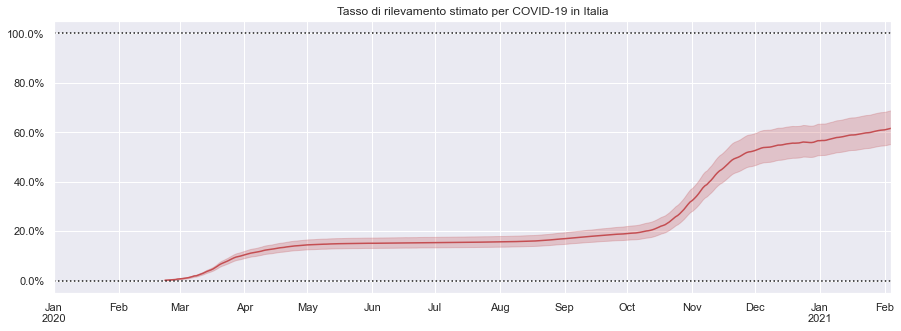

In [11]:
c_det_rate_adj_2 = DF.totale_casi.replace(0, np.nan).values[1:].reshape(-1, 1) / res2['c_alpha_adj']

fig, ax = plt.subplots(figsize=(15, 5))

ax.set(
    title='Tasso di rilevamento stimato per COVID-19 in Italia'
)
c_det_rate_adj_2.mu.plot(ax=ax, color='r')
ax.fill_between(
    c_det_rate_adj_2.index,
    c_det_rate_adj_2.lo, c_det_rate_adj_2.hi,
    alpha=.25, color='r',
    label='CI 95%'
)

ax.axhline(1, color='k', ls=':')
ax.axhline(0, color='k', ls=':')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
plt.show()

In [12]:
display(Markdown(f"""
L'attuale $\mathrm{{DR}}_t$ stimato è quindi pari a
{c_det_rate_adj_2.mu.values[-1]:.1%}
(95% CI: {c_det_rate_adj_2.hi.values[-1]:.1%}, {c_det_rate_adj_2.lo.values[-1]:.1%}),
ovvero si stima che
il **{1-c_det_rate_adj_2.mu.values[-1]:.1%} dei
casi suffigerebbe al rilevamento**
(95% CI: {1-c_det_rate_adj_2.lo.values[-1]:.1%}, {1-c_det_rate_adj_2.hi.values[-1]:.1%}).
"""))


L'attuale $\mathrm{DR}_t$ stimato è quindi pari a
61.6%
(95% CI: 55.3%, 68.9%),
ovvero si stima che
il **38.4% dei
casi suffigerebbe al rilevamento**
(95% CI: 31.1%, 44.7%).


# METODO

In [13]:
test_size = 60*4

In [14]:
par_df1, PDFs1, CDFs1, xDF1 = define_parameters(
    test_size,
    cov1 = 0.86,
    cov2 = 0.45,
    dt_incub_min = 4.1,
    dt_incub_max = 7.0,
    dt_onset_min = 12.8,
    dt_onset_max = 19.2,
    ifr_min = 5.75 / 100,
    ifr_max = 6.25 / 100,
    ci=.95,
)

In [15]:
def generate_cases(L, k, n_days=60*4, x0=60*2, start=0):
    x = np.arange(n_days)
    return x, (L / (1 + np.exp(-k * (x - x0)))).astype(int)

In [16]:
X, Y = generate_cases(L=1e6, k=.05, n_days=test_size, x0=60*2.75)

In [17]:
Z = np.zeros(test_size)
Z[int(par_df1.death.mu):] = Y[:-int(par_df1.death.mu)] * par_df1.IFR.mu

## Concetto di backcasting

Siano dati due eventi $\alpha$ e $\omega$.

Sia definita Alpha-Omega-Rate $\mathrm{A}\Omega\mathrm{R}$ la probabilità condizionata non nulla del verificarsi dell'evento $\omega$ in seguito all'osservazione dell'evento $\alpha$

$$
P(\omega | \alpha) = \mathrm{A}\Omega\mathrm{R} \;\,\; >0
$$

Sia posta pari a 1 la probabilità condizionata che si sia verificato $\alpha$ data l'osservazione di un evento $\omega$

$$
P(\alpha | \omega) = 1
$$

ovvero

- l'evento $\omega$ ha probabilità $\mathrm{A}\Omega\mathrm{R}$ di accadere in seguito ad un evento $\alpha$

- l'osservazione di un evento $\omega$ comporta sicuramente l'accadimento di un evento $\alpha$ nel passato

Pertanto, data l'osservazione di $n(\omega)$ eventi $\omega$, si può stimare che il numero $n(\alpha)$ di eventi $\alpha$ occorsi sia

$$
n(\alpha) = \frac{n(\omega)}{\mathrm{A}\Omega\mathrm{R}}
$$

Sia data una distribuzione di probabilità $p(\omega_{t_0 + \tau})$ nel tempo $t$ del verificarsi dell'evento $\omega_{t_0+\tau}$ dopo $\tau$ unità di tempo dall'osservazione dell'evento $\alpha_{t_0}$ al tempo $t_0$

$$
p(\omega_{t_0 + \tau}) = \mathbf{PDF}[\omega]_{t_0 + \tau}
$$

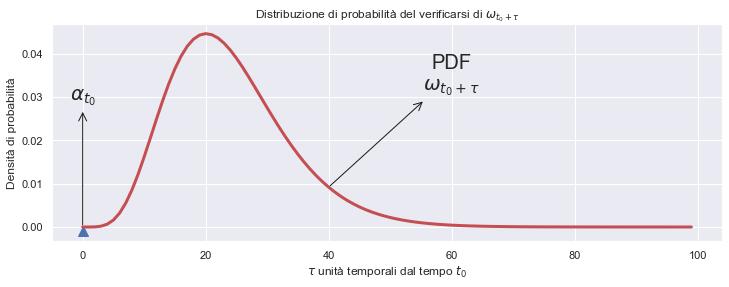

In [18]:
x_lim = 100

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(xDF1[:x_lim], PDFs1[2,:x_lim], lw=3, color='r')
ax.scatter(0, -0.001, marker='^', s=100)
ax.set(
    xlabel=r"$\tau$ unità temporali dal tempo $t_0$",
    ylabel="Densità di probabilità",
    title=r"Distribuzione di probabilità del verificarsi di $\omega_{t_0 + \tau}$"
)
ax.annotate(
    r"$\alpha_{t_0}$",
    xy=(0, 0),
    xytext=(0, .03),
    ha='center', va='center',
    fontsize=20,
    arrowprops=dict(color='k', arrowstyle='<-')
)
ax.annotate(
    "PDF\n"r"$\omega_{t_0 + \tau}$",
    xy=(40, PDFs1[2,40]),
    xytext=(60, .035),
    ha='center', va='center',
    fontsize=20,
    arrowprops=dict(color='k', arrowstyle='<-')
)
plt.show()

Noto il numero $n(\omega_t)$ di eventi $\omega$ nel tempo $t$, possiamo stimare che il numero $n(\alpha_{t_0})$ di eventi $\alpha$ occorsi in $t_0<t$ siano pari alla somma degli eventi $n(\omega_{t_0 + \tau})$ moltiplicati per la densità di probabilità $\mathbf{PDF}[\omega]_{t_0 + \tau}$ al tempo $t_0 + \tau$ divisa per la probabilità condizionata $p(\omega|\alpha)$

$$
n(\alpha_{t_0}) = \sum_{\tau=1}
\frac{
    n(\omega_{t_0 + \tau})
}{
    \mathrm{A}\Omega\mathrm{R}
} \mathbf{PDF}[\omega]_{t_0 + \tau}
$$

Indicando con $t=T$ l'ultimo giorno di osservazione, possiamo affermare che soprattutto negli ultimi giorni della serie temporale, il numero di eventi $n(\alpha)$ sarà ovviamente sottostimato perché i futuri eventi $\omega$, di cui potrebbero essere causa, non sono ancora accaduti.

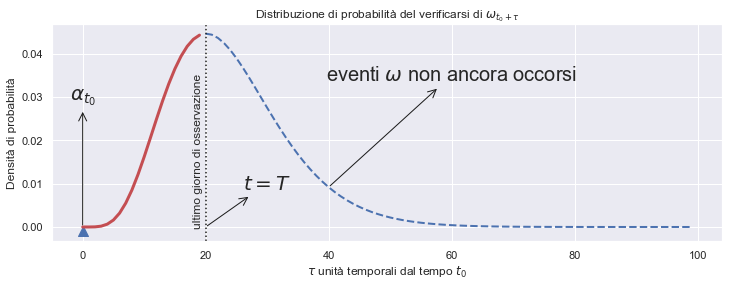

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(xDF1[:20], PDFs1[2,:20], lw=3, color='r')
ax.plot(xDF1[20:x_lim], PDFs1[2,20:x_lim], lw=2, ls='--', color='b')
ax.axvline(20, ls=':', color='k')
ax.scatter(0, -0.001, marker='^', s=100)
ax.set(
    xlabel=r"$\tau$ unità temporali dal tempo $t_0$",
    ylabel="Densità di probabilità",
    title=r"Distribuzione di probabilità del verificarsi di $\omega_{t_0 + \tau}$"
)
ax.text(
    19.5, 0,
    'ultimo giorno di osservazione',
    rotation=90, ha='right'
)
ax.annotate(
    r"$\alpha_{t_0}$",
    xy=(0, 0),
    xytext=(0, .03),
    ha='center', va='center',
    fontsize=20,
    arrowprops=dict(color='k', arrowstyle='<-')
)
ax.annotate(
    "eventi $\omega$ non ancora occorsi",
    xy=(40, PDFs1[2,40]),
    xytext=(60, .035),
    ha='center', va='center',
    fontsize=20,
    arrowprops=dict(color='k', arrowstyle='<-')
)
ax.annotate(
    "$t=T$",
    xy=(20, 0),
    xytext=(30, .01),
    ha='center', va='center',
    fontsize=20,
    arrowprops=dict(color='k', arrowstyle='<-')
)
plt.show()

Supponiamo, ad esempio, di avere i seguenti dati:

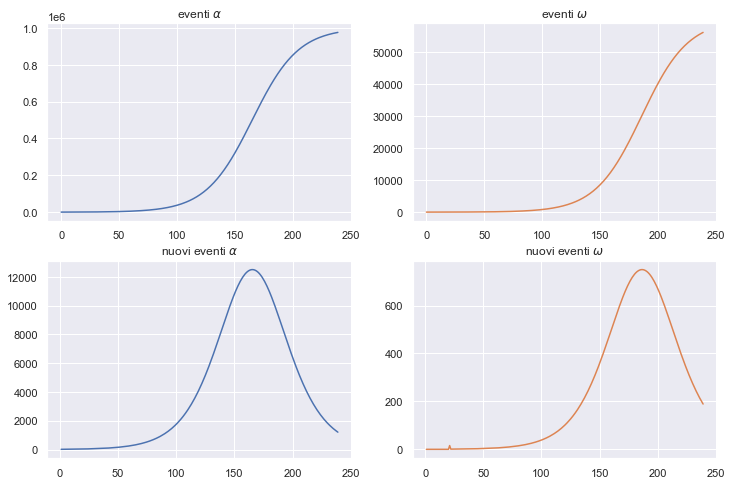

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0,0].plot(X, Y)
ax[0,0].set(
    title=r'eventi $\alpha$'
)

ax[0,1].plot(X, Z, color='C1')
ax[0,1].set(
    title=r'eventi $\omega$'
)

ax[1,0].plot(X[1:], np.diff(Y))
ax[1,0].set(
    title=r'nuovi eventi $\alpha$'
)

ax[1,1].plot(X[1:], np.diff(Z), color='C1')
ax[1,1].set(
    title=r'nuovi eventi $\omega$'
)


plt.show()

Vogliamo stimare il numero di eventi $n(\alpha)$ con metodo di backcasting dagli eventi $\omega$ noti e sapendo che la probabilità di osservare $\omega$ in conseguenza di $\alpha$ nel tempo $t$ è una distribuzione **Gamma** con i seguenti parametri di _shape_ e _scale_ (_scale_ è definita come 1/_rate_)

In [21]:
t_df = par_df1[['IFR', 'alpha', 'beta']].copy(deep=True)
t_df.columns = ['AΩR', 'shape', 'scale']
t_df.index = ['CI 2.5%', 'median', 'CI 97.5%']
print(t_df.to_string())

               AΩR     shape     scale
CI 2.5%   0.058724  6.242729  3.071975
median    0.060000  6.223439  3.462716
CI 97.5%  0.061276  6.205696  3.854925


In [22]:
res1 = backcasting(
    np.concatenate(([0], np.diff(Z))), par_df1.IFR.values, PDFs1, CDFs1, range(Z.size),
)

Notiamo la sottostima nell'ultima parte della serie temporale dovuta agli eventi $\omega$ non ancora occorsi e la "caduta a zero" dei nuovi eventi $\alpha$ stimati in $t=T$: per l'ultimo giorno della serie temporale non si ha alcun dato futuro da cui stimare i probabili eventi $\alpha$.

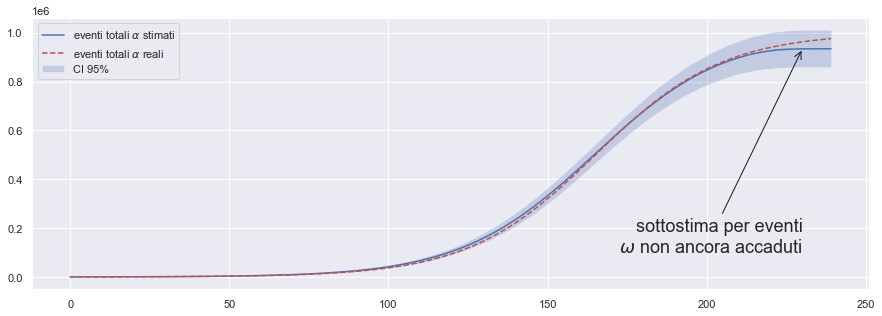

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))
res1['c_alpha_raw'].mu.plot(ax=ax, label=r'eventi totali $\alpha$ stimati')
ax.fill_between(
    res1['c_alpha_raw'].index,
    res1['c_alpha_raw'].lo, res1['c_alpha_raw'].hi,
    alpha=.25,
    label='CI 95%'
)
ax.plot(X, Y, color='r', ls='--', label=r'eventi totali $\alpha$ reali')
ax.annotate(
    'sottostima per eventi\n'r'$\omega$ non ancora accaduti',
    xy=(230, res1['c_alpha_raw'].mu.values[230]),
    xytext=(230, 1e5),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=18, ha='right'
)
ax.legend()
plt.show()

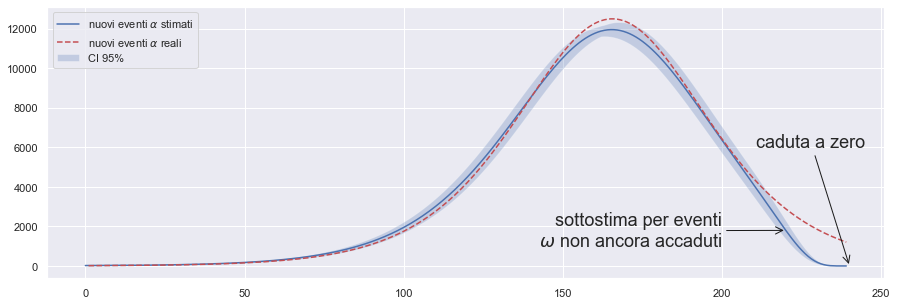

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))
res1['d_alpha_raw'].mu.plot(ax=ax, label=r'nuovi eventi $\alpha$ stimati')
ax.fill_between(
    res1['d_alpha_raw'].index,
    res1['d_alpha_raw'].lo, res1['d_alpha_raw'].hi,
    alpha=.25,
    label='CI 95%'
)
ax.plot(X[1:], np.diff(Y), color='r', ls='--', label=r'nuovi eventi $\alpha$ reali')
ax.annotate(
    'sottostima per eventi\n'r'$\omega$ non ancora accaduti',
    xy=(220, res1['d_alpha_raw'].mu.values[220]),
    xytext=(200, 1e3),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=18, ha='right'
)
ax.annotate(
    'caduta a zero',
    xy=(240, res1['d_alpha_raw'].mu.values[239]),
    xytext=(245, 6e3),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=18, ha='right'
)

ax.legend(loc='upper left')
plt.show()

## Correzione temporale

Nota la distribuzione di probabilità del verificarsi dell'evento $\omega$ in seguito ad $\alpha$ nel tempo $t$ e indicato con $t=T$ l'ultimo giorno di osservazione, la probabilità $p(\alpha|\omega)_{t_0}$ di aver osservato tutti gli eventi $\omega$ causati dagli eventi $\alpha$ nel tempo $[t_0...T]$ è esprimibile come la densità di probabilità cumulativa di $\omega$ al tempo $t=T-t_0$

$$
p(\alpha|\omega)_{t_0} = \mathbf{CDF}[\omega]_{T-t_0}
$$

possiamo perciò correggere il numero di eventi $n(\alpha_{t_0})$ stimati dividendo per la probabilità $p(\alpha|\omega)_{t_0}$

$$
n(\alpha_{t_0}) = \sum_{\tau=1}^{T} 
\frac{
    n(\omega_{t_0+\tau})
}{
    \mathrm{A}\Omega\mathrm{R}
}
\frac{
    \mathbf{PDF}[\omega]_{t_0+\tau}
}{
    \mathbf{CDF}[\omega]_{T-t_0}
}
$$

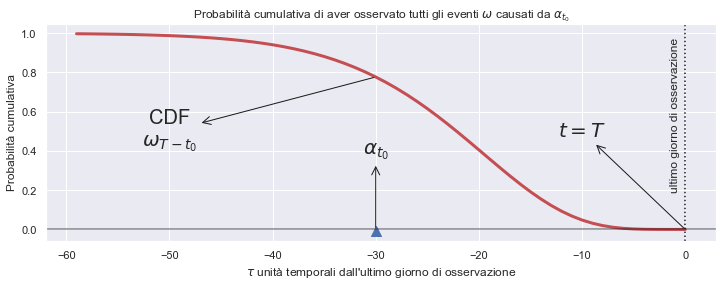

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(xDF1[-60:]-test_size+1, CDFs1[2,::-1][-60:], lw=3, color='r')
ax.axhline(0, color='k', alpha=.5)
ax.axvline(0, ls=':', color='k')
ax.scatter(-30, -.01, marker='^', s=100)
ax.set(
    xlabel=r"$\tau$ unità temporali dall'ultimo giorno di osservazione",
    ylabel="Probabilità cumulativa",
    title=r"Probabilità cumulativa di aver osservato tutti gli eventi $\omega$ causati da $\alpha_{t_0}$"
)
ax.text(
    -.5, .2,
    'ultimo giorno di osservazione',
    rotation=90, ha='right'
)
ax.annotate(
    r"$\alpha_{t_0}$",
    xy=(-30, 0),
    xytext=(-30, .4),
    ha='center', va='center',
    fontsize=20,
    arrowprops=dict(color='k', arrowstyle='<-')
)
ax.annotate(
    r"$t=T$",
    xy=(0, 0),
    xytext=(-10, .5),
    ha='center', va='center',
    fontsize=20,
    arrowprops=dict(color='k', arrowstyle='<-')
)
ax.annotate(
    "CDF\n$\omega_{T-t_0}$",
    xy=(-30, CDFs1[2,::-1][-31]),
    xytext=(-50, .5),
    ha='center', va='center',
    fontsize=20,
   arrowprops=dict(color='k', arrowstyle='<-')
)
plt.show()

Notiamo che nonostante la correzione abbia evitato la "caduta a zero" dei nuovi eventi $\alpha$ e la sottostima, ora siamo di fronte ad una sovrastima: la correzione effettuata non è in grado di "prevedere" i futuri eventi $\omega$ ma solamente di stimare la probabilità di aver osservato in $t_0$ tutti gli eventi $\omega$ causati da $\alpha$.

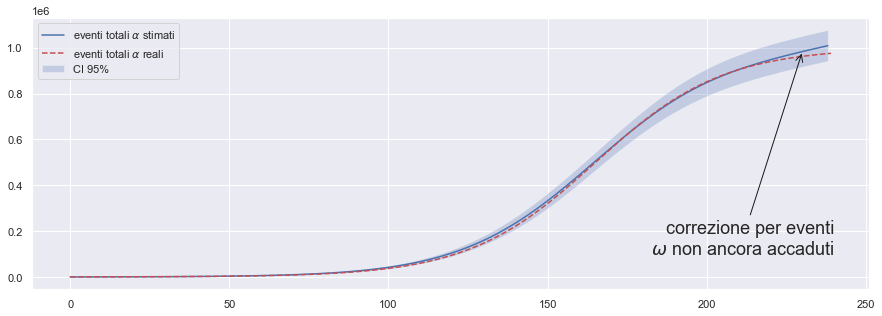

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
res1['c_alpha_cor'].mu.plot(ax=ax, label=r'eventi totali $\alpha$ stimati')
ax.fill_between(
    res1['c_alpha_cor'].index,
    res1['c_alpha_cor'].lo, res1['c_alpha_cor'].hi,
    alpha=.25,
    label='CI 95%'
)
ax.plot(X, Y, color='r', ls='--', label=r'eventi totali $\alpha$ reali')
ax.annotate(
    'correzione per eventi\n'r'$\omega$ non ancora accaduti',
    xy=(230, res1['c_alpha_cor'].mu.values[230]),
    xytext=(240, 1e5),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=18, ha='right'
)
ax.legend()
plt.show()

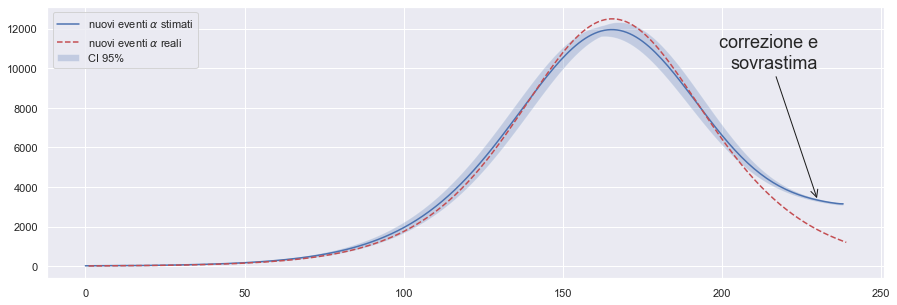

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
res1['d_alpha_cor'].mu.plot(ax=ax, label=r'nuovi eventi $\alpha$ stimati')

ax.fill_between(
    res1['d_alpha_cor'].index,
    res1['d_alpha_cor'].lo, res1['d_alpha_cor'].hi,
    alpha=.25,
    label='CI 95%'
)
ax.plot(X[1:], np.diff(Y), color='r', ls='--', label=r'nuovi eventi $\alpha$ reali')
ax.annotate(
    'correzione e\nsovrastima',
    xy=(230, res1['d_alpha_cor'].mu[230]),
    xytext=(230, 10000),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=18, ha='right'
)
ax.legend(loc='upper left')
plt.show()

## Aggiustamento

Possiamo perciò ottenere un'aggiustamento della sovrastima dovuta alla correzione, prendendo la media degli $n(\alpha)$ stimati grezzi e corretti

$$
n(\alpha_{t_0}) = \frac{1}{2} \left[ \sum_{\tau=1}^{T} 
\frac{
    n(\omega_{t_0+\tau})
}{
    \mathrm{A}\Omega\mathrm{R}
}
\frac{
    \mathbf{PDF}[\omega]_{t_0+\tau}
}{
    \mathbf{CDF}[\omega]_{T-t_0}
} +
\sum_{\tau=1}^{T} 
\frac{
    n(\omega_{t_0+\tau})
}{
    \mathrm{A}\Omega\mathrm{R}
}
    \mathbf{PDF}[\omega]_{t_0+\tau}
\right]
$$

ovvero

$$
n(\alpha_{t_0}) = \frac{1}{2}
\left[
\frac{1}{\mathbf{CDF}[\omega]_{T-t_0}}+1
\right]
\sum_{\tau=1}^{T} 
\frac{
    n(\omega_{t_0+\tau})
}{
    \mathrm{A}\Omega\mathrm{R}
}
    \mathbf{PDF}[\omega]_{t_0+\tau}
$$

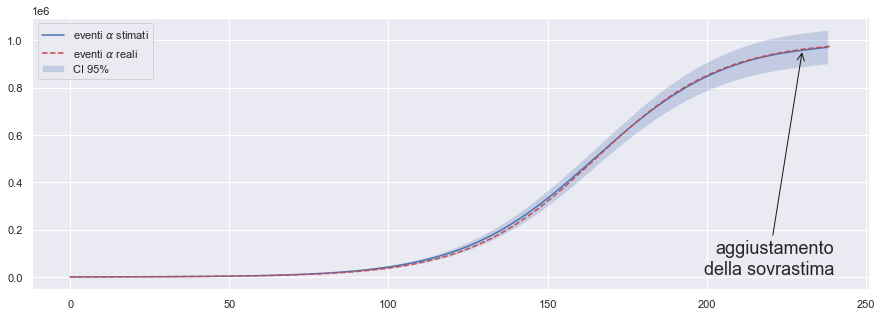

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
res1['c_alpha_adj'].mu.plot(ax=ax, label=r'eventi $\alpha$ stimati')

ax.fill_between(
    res1['c_alpha_adj'].index,
    res1['c_alpha_adj'].lo, res1['c_alpha_adj'].hi,
    alpha=.25,
    label='CI 95%'
)
ax.plot(X, Y, color='r', ls='--', label=r'eventi $\alpha$ reali')
ax.annotate(
    'aggiustamento\ndella sovrastima',
    xy=(230, res1['c_alpha_adj'].mu[230]),
    xytext=(240, 10000),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=18, ha='right'
)
ax.legend(loc='upper left')
plt.show()

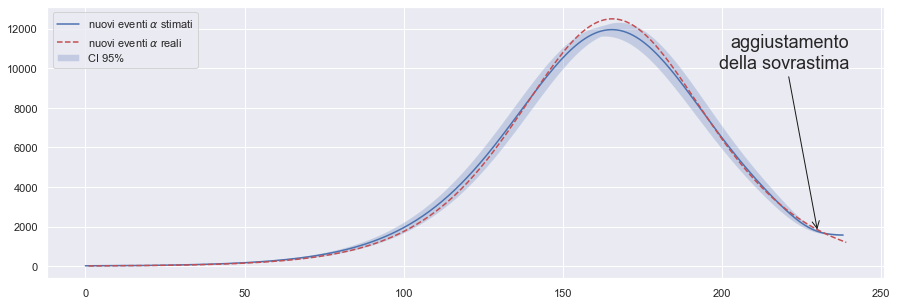

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
res1['d_alpha_adj'].mu.plot(ax=ax, label=r'nuovi eventi $\alpha$ stimati')

ax.fill_between(
    res1['d_alpha_adj'].index,
    res1['d_alpha_adj'].lo, res1['d_alpha_adj'].hi,
    alpha=.25,
    label='CI 95%'
)
ax.plot(X[1:], np.diff(Y), color='r', ls='--', label=r'nuovi eventi $\alpha$ reali')
ax.annotate(
    'aggiustamento\ndella sovrastima',
    xy=(230, res1['d_alpha_adj'].mu[230]),
    xytext=(240, 10000),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=18, ha='right'
)
ax.legend(loc='upper left')
plt.show()

## COVID-19 in Italia

Se definiamo

- $\alpha$: infezione da SARS-CoV-2
- $\omega$: decesso per COVID-19
- $\mathrm{A}\Omega\mathrm{R}$: Infection Fatality Rate $\mathrm{IFR}$ per COVID-19
- $\mathbf{PDF}[\omega]$: distribuzione di probabilità del tempo dall'infezione all'eventuale decesso per COVID-19

data l'osservazione dei decessi giornalieri per COVID-19 possiamo stimare le infezioni occorse precedentemente.

I dati dei decessi e dei casi osservati dal repository GitHub COVID-19 del [Dipartimento di Protezione Civile](https://github.com/pcm-dpc/COVID-19).

L'IFR stimato per l'Italia è tratto da Imperial College Report 34 [Brazeau, Verity et al. 2020](https://www.imperial.ac.uk/mrc-global-infectious-disease-analysis/covid-19/report-34-IFR/) (tabella pag 9).

I parametri per la distribuzione dell'intervallo dall'infezione al decesso sono tratti da [Phipps et al. 2020](https://doi.org/10.1098/rsos.200909).

Sappiamo dunque che:

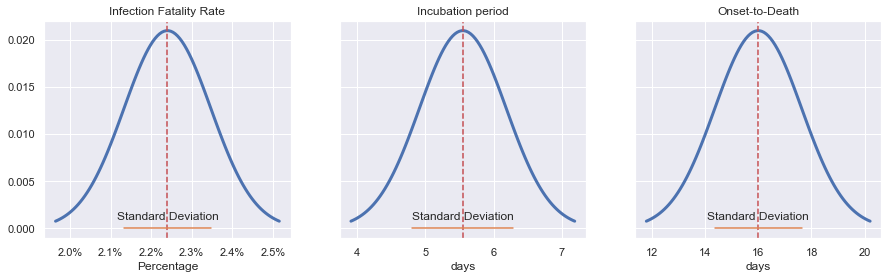

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

ifr_dist = sps.norm(loc=par_df2.IFR.mu, scale=par_df2.IFR.mu-par_df2.IFR.lo)
ifr_X = np.linspace(ifr_dist.ppf(.005), ifr_dist.ppf(1-.005), 100)
ifr_Y = ifr_dist.pdf(ifr_X)
ifr_Y /= ifr_Y.sum()
ax[0].plot(ifr_X, ifr_Y, lw=3)
ax[0].axvline(par_df2.IFR.mu, ls='--', color='r')
ax[0].plot([par_df2.IFR.lo, par_df2.IFR.hi], [0,0])
ax[0].text(
    .5, .075,
    'Standard Deviation',
    ha='center', va='bottom',
    transform=ax[0].transAxes
)
ax[0].set_title('Infection Fatality Rate')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
ax[0].set(
    xlabel='Percentage'
)

dt_incubation_dist = sps.norm(loc=par_df2.incub.mu, scale=par_df2.incub_sd.mu-par_df2.incub_sd.lo)
dt_incubation_X = np.linspace(dt_incubation_dist.ppf(.005), dt_incubation_dist.ppf(1-.005), 100)
dt_incubation_Y = dt_incubation_dist.pdf(dt_incubation_X)
dt_incubation_Y /= dt_incubation_Y.sum()
ax[1].plot(dt_incubation_X, dt_incubation_Y, lw=3)
ax[1].axvline(par_df2.incub.mu, ls='--', color='r')
ax[1].plot([par_df2.incub.lo, par_df2.incub.hi], [0,0])
ax[1].text(
    .5, .075,
    'Standard Deviation',
    ha='center', va='bottom',
    transform=ax[1].transAxes
)
ax[1].set_title('Incubation period')
ax[1].set(
    xlabel='days'
)

dt_onset_dist = sps.norm(loc=par_df2.onset.mu, scale=par_df2.onset.mu-par_df2.onset.lo)
dt_onset_X = np.linspace(dt_onset_dist.ppf(.005), dt_onset_dist.ppf(1-.005), 100)
dt_onset_Y = dt_onset_dist.pdf(dt_onset_X)
dt_onset_Y /= dt_onset_Y.sum()
ax[2].plot(dt_onset_X, dt_onset_Y, lw=3)
ax[2].axvline(par_df2.onset.mu, ls='--', color='r')
ax[2].plot([par_df2.onset.lo, par_df2.onset.hi], [0,0])
ax[2].text(
    .5, .075,
    'Standard Deviation',
    ha='center', va='bottom',
    transform=ax[2].transAxes
)
ax[2].set_title('Onset-to-Death')
ax[2].set(
    xlabel='days'
)

plt.show()

In [31]:
t_df2 = par_df2[['IFR', 'alpha', 'beta']].copy(deep=True)
t_df2.columns = ['IFR', 'shape', 'scale']
t_df2.index = ['CI 2.5%', 'median', 'CI 97.5%']
print(t_df2.to_string())

               IFR     shape     scale
CI 2.5%   0.021329  6.242729  3.071975
median    0.022400  6.223439  3.462716
CI 97.5%  0.023471  6.205696  3.854925


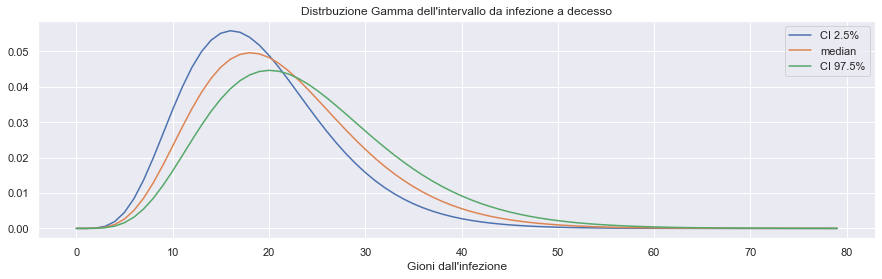

In [32]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(xDF2[:80], PDFs2[0,:80], label='CI 2.5%')
ax.plot(xDF2[:80], PDFs2[1,:80], label='median')
ax.plot(xDF2[:80], PDFs2[2,:80], label='CI 97.5%')
ax.set(
    title="Distrbuzione Gamma dell'intervallo da infezione a decesso",
    xlabel="Gioni dall'infezione"
)
ax.legend()
plt.show()

In [33]:
res2a = backcasting(
    n_dfat[:402], par_df2.IFR.values, PDFs2, CDFs2, DF.index[:402],
)

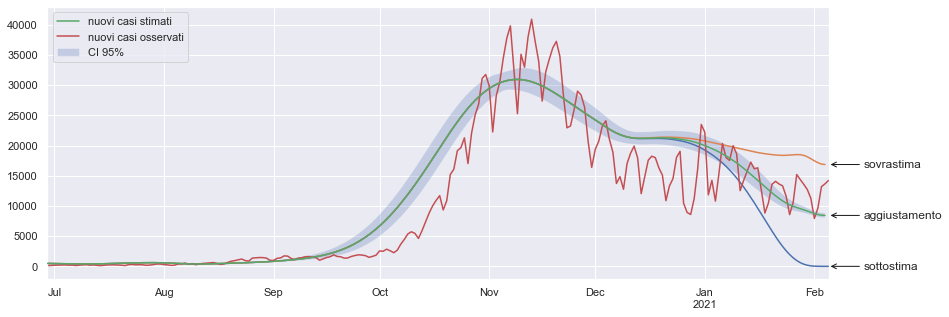

In [34]:
fig, ax = plt.subplots(figsize=(14, 5))
res2a['d_alpha_raw'].mu.plot(ax=ax, label='')
res2a['d_alpha_cor'].mu.plot(ax=ax, label='')
res2a['d_alpha_adj'].mu.plot(ax=ax, zorder=100, label='nuovi casi stimati')
ax.fill_between(
    res2a['d_alpha_adj'].index,
    res2a['d_alpha_adj'].lo, res2a['d_alpha_adj'].hi,
    alpha=.25, label='CI 95%'
)
DF.plot(y='nuovi_positivi', ax=ax, label='nuovi casi osservati')

ax.annotate(
    'sovrastima',
    xy=(DF.index[-1], res2a['d_alpha_cor'].mu.values[-1]),
    xytext=(DF.index[-1]+pd.Timedelta(days=10), res2a['d_alpha_cor'].mu.values[-1]),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=12, ha='left', va='center'
)
ax.annotate(
    'sottostima',
    xy=(DF.index[-1], res2a['d_alpha_raw'].mu.values[-1]),
    xytext=(DF.index[-1]+pd.Timedelta(days=10), res2a['d_alpha_raw'].mu.values[-1]),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=12, ha='left', va='center'
)
ax.annotate(
    'aggiustamento',
    xy=(DF.index[-1], res2a['d_alpha_adj'].dropna().mu.values[-1]),
    xytext=(DF.index[-1]+pd.Timedelta(days=10), res2a['d_alpha_adj'].dropna().mu.values[-1]),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=12, ha='left', va='center'
)
ax.set(
    xlim=(DF.index[30*6], ax.get_xlim()[1])
)
ax.legend(loc='upper left')
plt.show()

## Confronto con Monte Carlo

Confrontiamo dunque i risultati dell'algoritmo di backcasting veloce implementato da EpiData.it con le simulazioni Monte Carlo dell'implementazione di [Phipps et al. 2020](https://doi.org/10.1098/rsos.200909).

In [35]:
phipps_data = pd.read_csv(
    'italy_dcases_ddeaths_20200914.csv',
    header=None
)

In [36]:
phipps_data.columns = ['dcases', 'ddeaths']

In [37]:
_ = """fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(phipps_data.ddeaths.values[2:], lw=3)
ax.plot(DF.nuovi_deceduti.values[:259], marker='.', ls='none')"""

In [38]:
par_df3, PDFs3, CDFs3, xDF3 = define_parameters(
    phipps_data.index.size,
    dt_incub_min = 4.1,
    dt_incub_max = 7.0,
    dt_onset_min = 12.8,
    dt_onset_max = 19.2,
    ifr_min = 0.0037,
    ifr_max = 0.0115,
    ci=.95,
)

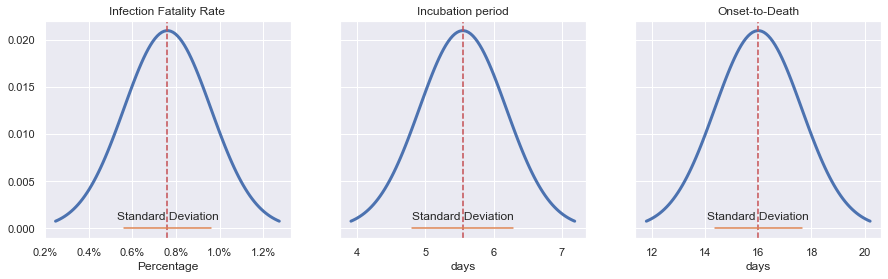

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

ifr_dist = sps.norm(loc=par_df3.IFR.mu, scale=par_df3.IFR.mu-par_df3.IFR.lo)
ifr_X = np.linspace(ifr_dist.ppf(.005), ifr_dist.ppf(1-.005), 100)
ifr_Y = ifr_dist.pdf(ifr_X)
ifr_Y /= ifr_Y.sum()
ax[0].plot(ifr_X, ifr_Y, lw=3)
ax[0].axvline(par_df3.IFR.mu, ls='--', color='r')
ax[0].plot([par_df3.IFR.lo, par_df3.IFR.hi], [0,0])
ax[0].text(
    .5, .075,
    'Standard Deviation',
    ha='center', va='bottom',
    transform=ax[0].transAxes
)
ax[0].set_title('Infection Fatality Rate')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
ax[0].set(
    xlabel='Percentage'
)

dt_incubation_dist = sps.norm(loc=par_df3.incub.mu, scale=par_df3.incub_sd.mu-par_df3.incub_sd.lo)
dt_incubation_X = np.linspace(dt_incubation_dist.ppf(.005), dt_incubation_dist.ppf(1-.005), 100)
dt_incubation_Y = dt_incubation_dist.pdf(dt_incubation_X)
dt_incubation_Y /= dt_incubation_Y.sum()
ax[1].plot(dt_incubation_X, dt_incubation_Y, lw=3)
ax[1].axvline(par_df3.incub.mu, ls='--', color='r')
ax[1].plot([par_df3.incub.lo, par_df3.incub.hi], [0,0])
ax[1].text(
    .5, .075,
    'Standard Deviation',
    ha='center', va='bottom',
    transform=ax[1].transAxes
)
ax[1].set_title('Incubation period')
ax[1].set(
    xlabel='days'
)

dt_onset_dist = sps.norm(loc=par_df3.onset.mu, scale=par_df3.onset.mu-par_df3.onset.lo)
dt_onset_X = np.linspace(dt_onset_dist.ppf(.005), dt_onset_dist.ppf(1-.005), 100)
dt_onset_Y = dt_onset_dist.pdf(dt_onset_X)
dt_onset_Y /= dt_onset_Y.sum()
ax[2].plot(dt_onset_X, dt_onset_Y, lw=3)
ax[2].axvline(par_df3.onset.mu, ls='--', color='r')
ax[2].plot([par_df3.onset.lo, par_df3.onset.hi], [0,0])
ax[2].text(
    .5, .075,
    'Standard Deviation',
    ha='center', va='bottom',
    transform=ax[2].transAxes
)
ax[2].set_title('Onset-to-Death')
ax[2].set(
    xlabel='days'
)

plt.show()

In [40]:
t_df3 = par_df3[['IFR', 'alpha', 'beta']].copy(deep=True)
t_df3.columns = ['IFR', 'shape', 'scale']
t_df3.index = ['CI 2.5%', 'median', 'CI 97.5%']
print(t_df3.to_string())

              IFR     shape     scale
CI 2.5%   0.00561  6.242729  3.071975
median    0.00760  6.223439  3.462716
CI 97.5%  0.00959  6.205696  3.854925


La distribuzione **Gamma** dell'intervallo da infezione a decesso è il medesimo utilizzato sopra.

L'IFR generico usato nel lavoro di Phipps et al è invece molto minore rispetto a quello usato da noi e stimato dall'Imperial College per l'Italia: differenti nazioni hanno verosimilmente differenti IFR dovuti soprattutto alla distribuzione delle fascie d'età nella popolazione. L'Italia è nazione piuttosto "anziana" ed ha pertanto un IFR verosimilmente più elevato rispetto a nazioni più "giovani".

Per questo motivo, non confronteremo i risultati delle due stime con i casi osservati ma solamente tra loro per verificare che il metodo di stima di EpiData.it dia risultati sovrapponibili alle simulazioni Monte Carlo di Phipps et al. (casi dal 1 Gennaio 2020 al 14 Settembre 2020).

In [41]:
dt_start = dt.datetime.now()

In [42]:
res3 = backcasting(
    phipps_data.ddeaths.values, par_df3.IFR.values, PDFs3, CDFs3, phipps_data.index,
)

In [43]:
dt_end = dt.datetime.now()

Si noti che l'implementazione di Phipps et al. con metodo Monte Carlo comporta 10'000 simulazioni che, in un normale personal computer, prendono qualche ora di tempo per una serie temporale come quella di COVID-19.

L'algoritmo implementato qui e visualizzabile su GitHub (come tutto il sito EpiData.it) all'indirizzo [Real_infected](https://github.com/maxdevblock/covid-19-website/blob/master/Italia/Real_infected.ipynb) è stato eseguito in:

In [44]:
dt_delta = dt_end - dt_start
print('Eseguito in', dt_delta)

Eseguito in 0:00:00.123783


In [45]:
phipps = pd.read_csv(
    'cumulative_infections_v9_italy_20200914.txt',
    index_col='day0'
)

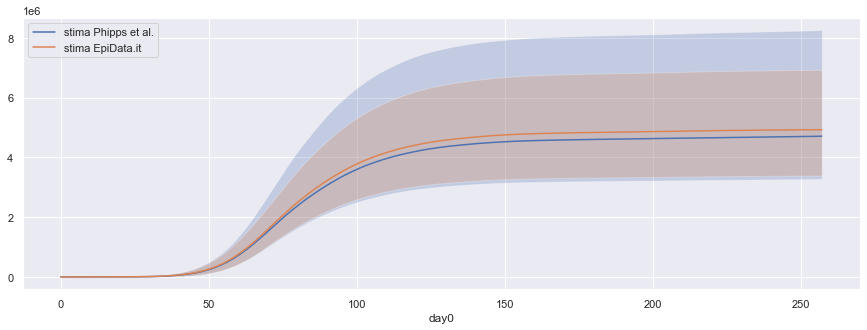

In [46]:
ax = phipps[:-1].plot(y='n_inf_median', figsize=(15, 5), label='stima Phipps et al.')
ax.fill_between(
    phipps.index[:-1],
    phipps.n_inf_02p5[:-1], phipps.n_inf_97p5[:-1],
    alpha=.25
)

ax.plot(res3['c_alpha_adj'].mu.values, label='stima EpiData.it')
ax.fill_between(
    res3['c_alpha_adj'].index,
    res3['c_alpha_adj'].lo.values, res3['c_alpha_adj'].hi.values,
    alpha=.25
)
ax.legend(loc='upper left')
plt.show()

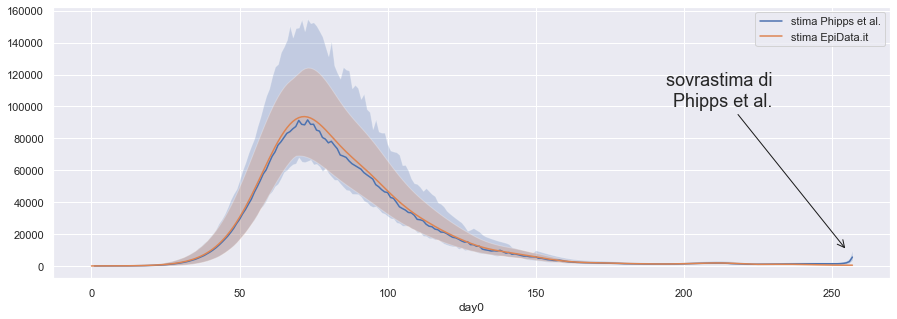

In [47]:
ax = phipps[:-1].diff().plot(y='n_inf_median', figsize=(15, 5), label='stima Phipps et al.')
ax.fill_between(
    phipps.index[:-1],
    phipps.n_inf_02p5[:-1].diff(), phipps.n_inf_97p5[:-1].diff(),
    alpha=.25
)
res3['d_alpha_adj'].mu.plot(ax=ax, label='stima EpiData.it')
ax.fill_between(
    res3['d_alpha_adj'].index,
    res3['d_alpha_adj'].lo.values, res3['d_alpha_adj'].hi.values,
    alpha=.25
)
ax.annotate(
    'sovrastima di\nPhipps et al.',
    xy=(255, 1e4),
    xytext=(230, 1e5),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=18, ha='right'
)

ax.legend()
plt.show()